In [1]:
import pandas as pd
import numpy as np

import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

import date_fixer

from googletrans import Translator

In [2]:
#example using translator Arabic to Engligh
translator = Translator()

translation = translator.translate("مرحبا كيف حالك؟",  dest='en')
translation.text

'Hello how are you?'

In [3]:
#example using translator English to Arabic
translator = Translator()

translation = translator.translate("Hello, how are you?",  dest='ar')
translation.text

'مرحبًاّ! كيف حالك؟'

In [4]:
new = pd.read_csv('daily8_3.csv')
new['dateline'] = pd.to_datetime(new['dateline'])
df = new

In [5]:
def encode_sentiment(df, columns_to_encode):
    dummies_list = columns_to_encode

    dummy_df = pd.get_dummies(df[dummies_list], drop_first=False)
    encoded = pd.concat([df, dummy_df], axis = 1)
    return encoded

In [6]:
encoded = encode_sentiment(df, 'text_label')

<AxesSubplot:xlabel='dateline', ylabel='Count'>

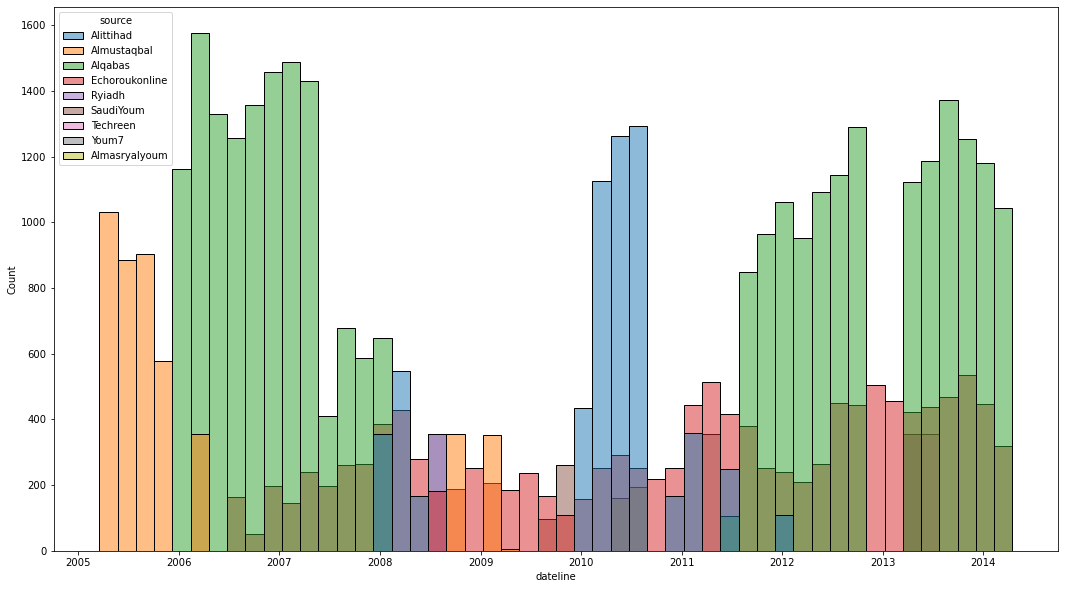

In [7]:
plt.figure(figsize = (18, 10))
sns.histplot(data=encoded, x='dateline', hue= 'source', bins=50)

<Figure size 1296x864 with 0 Axes>

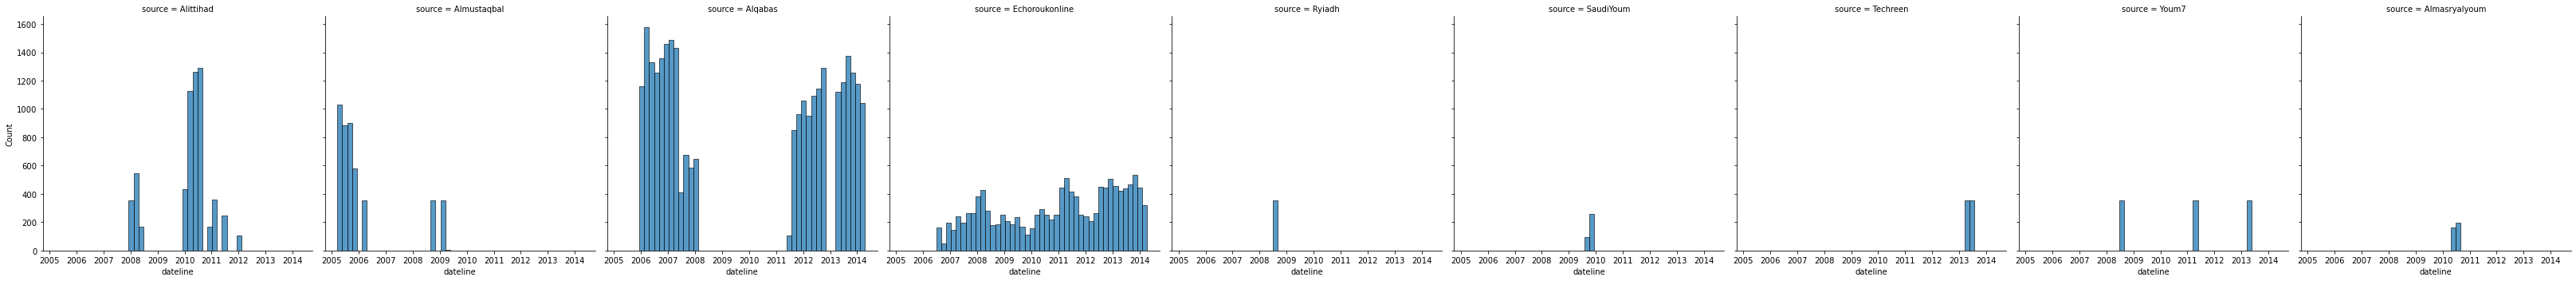

In [8]:
plt.figure(figsize = (18, 12))
sns.displot(data=encoded, x='dateline', col= 'source', bins=50)

In [9]:
df = encoded.set_index('dateline').sort_index()

In [10]:
df.columns

Index(['index', 'id', 'url', 'headline', 'text', 'tags', 'source',
       'text_label', 'text_score', 'headline_label', 'headline_score', 'False',
       'negative', 'neutral', 'positive'],
      dtype='object')

In [11]:
df.shape

(54162, 15)

In [12]:
df.info

<bound method DataFrame.info of             index               id  \
dateline                             
2005-03-18      0  MTL_ARB_0409327   
2005-03-18      1  MTL_ARB_0409331   
2005-03-19     12  MTL_ARB_0409472   
2005-03-19     13  MTL_ARB_0409500   
2005-03-19     11  MTL_ARB_0409454   
...           ...              ...   
2014-04-15    351  SHG_ARB_0136218   
2014-04-16    352  SHG_ARB_0136306   
2014-04-16    353  SHG_ARB_0136310   
2014-04-16    354  SHG_ARB_0136314   
2014-04-17    356  SHG_ARB_0136406   

                                                          url  \
dateline                                                        
2005-03-18  http://www.almustaqbal.com/v4/article.aspx?typ...   
2005-03-18  http://www.almustaqbal.com/v4/article.aspx?typ...   
2005-03-19  http://www.almustaqbal.com/v4/article.aspx?typ...   
2005-03-19  http://www.almustaqbal.com/v4/article.aspx?typ...   
2005-03-19  http://www.almustaqbal.com/v4/article.aspx?typ...   
...               

In [13]:
df.headline_label.value_counts()

neutral     36698
negative    13327
positive     4137
Name: headline_label, dtype: int64

In [14]:
df.tags.value_counts()

['واشنطن']                                                                  11218
['القاعدة']                                                                 11201
['بوش']                                                                      9074
['أمريكا']                                                                   3199
['فيسبوك']                                                                   2528
                                                                            ...  
['واشنطن', 'مركز التجارة العالمي', 'القاعدة']                                   1
['أمريكا', 'بوش', 'أوباما', 'تشيني', '11 سبتمبر', 'القاعدة']                    1
['أمريكا', 'واشنطن', 'بوش', 'أوباما', 'مركز التجارة العالمي', 'القاعدة']        1
['أمريكا', 'بوش', 'أوباما', 'أسامة بن لادن']                                    1
['بوش', 'آل غور', 'القاعدة']                                                    1
Name: tags, Length: 435, dtype: int64

In [15]:
df.text_label.value_counts()

neutral     29728
False       15151
negative     7504
positive     1779
Name: text_label, dtype: int64

In [16]:
df.source.value_counts()

Alqabas           27998
Echoroukonline    12773
Alittihad          6069
Almustaqbal        4466
Youm7              1071
Techreen            714
Ryiadh              357
SaudiYoum           357
Almasryalyoum       357
Name: source, dtype: int64

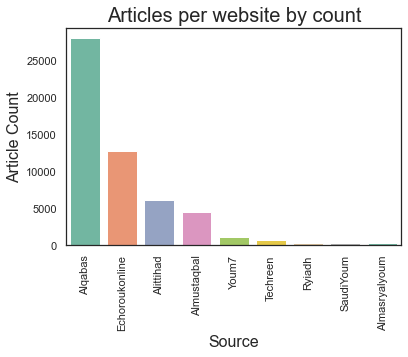

In [17]:
sns.set_theme(style="white")
ax = sns.countplot(x="source", data=df, palette="Set2",order = new['source'].value_counts().index)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Source', size = 16)
ax.set_ylabel('Article Count', size = 16)
ax.set_title("Articles per website by count", size = 20)
plt.show()

In [18]:
def country_tagger(df):
    country_map = { 'Alittihad': 'emirates',
                    'Echoroukonline': 'algeria',
                    'Ryiadh': 'ksa',
                    'SaudiYoum': 'ksa',
                    'Techreen': 'syria',
                    'Alqabas': 'kuwait',
                    'Almustaqbal': 'lebanon',
                    'Almasryalyoum': 'egypt',
                    'Youm7': 'egypt',
                    'Sabanews': 'yemen',
                    }
    df['country'] = df.source.map(country_map)
    return df

In [19]:
country_tagger(df)

,index,id,url,headline,text,tags,source,text_label,text_score,headline_label,headline_score,False,negative,neutral,positive,country
dateline,,,,,,,,,,,,,,,,
2005-03-18,0,MTL_ARB_0409327,http://www.almustaqbal.com/v4/article.aspx?typ...,قداس في ديترويت لروح الرئيس الشهيد ورفاقه عاقو...,جاء في تقرير عن الصلاة التي أقيمت في كاتدرائية...,['واشنطن'],Almustaqbal,False,False,negative,0.582857,1,0,0,0,lebanon
2005-03-18,1,MTL_ARB_0409331,http://www.almustaqbal.com/v4/article.aspx?typ...,"""""لا فرق بين الطائف والـ 1559 وعلى الدولة الاح...",دعا البطريرك الماروني الكاردينال مار نصرالله ب...,['بوش'],Almustaqbal,False,False,negative,0.608519,1,0,0,0,lebanon
2005-03-19,12,MTL_ARB_0409472,http://www.almustaqbal.com/v4/article.aspx?typ...,شدّد على انسحاب سوري فوري وانتخابات حرة بإشراف...,شدد نائب مساعد وزيرة الخارجية الأميركية دايفيد...,"['واشنطن', 'بوش']",Almustaqbal,False,False,neutral,0.987818,1,0,0,0,lebanon
2005-03-19,13,MTL_ARB_0409500,http://www.almustaqbal.com/v4/article.aspx?typ...,استقالة السفير الأميركي في أنقرة بعد انتقاده ز...,انقرة ـ حسني محلي والوكالات\nأعلن ناطق باسم ال...,"['واشنطن', 'بوش']",Almustaqbal,False,False,neutral,0.823856,1,0,0,0,lebanon
2005-03-19,11,MTL_ARB_0409454,http://www.almustaqbal.com/v4/article.aspx?typ...,دعا الى تغيير ذهنية الماضي التي أوصلتنا الى ال...,"جبيل ـ """"المستقبل""""\nرأى العماد ميشال عون أن ت...",['بوش'],Almustaqbal,False,False,neutral,0.560592,1,0,0,0,lebanon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-04-15,351,SHG_ARB_0136218,http://www.echoroukonline.com/ara/articles/201...,أوباما لبوتين: على كل القوات غير النظامية في أ...,أبلغ الرئيس الأمريكي باراك أوباما نظيره الروسي...,['أوباما'],Echoroukonline,neutral,0.9611957669258118,neutral,0.769957,0,0,1,0,algeria
2014-04-16,352,SHG_ARB_0136306,http://www.echoroukonline.com/ara/articles/201...,"بعد 10 سنوات على الفضيحة.. غلق سجن """"أبو غريب""""",أعلن وزير العدل العراقي حسن الشمري، الثلاثاء، ...,"['واشنطن', 'القاعدة']",Echoroukonline,False,False,negative,0.773513,1,0,0,0,algeria
2014-04-16,353,SHG_ARB_0136310,http://www.echoroukonline.com/ara/articles/201...,شرطة نيويورك تحل وحدة خاصة للتجسس على المسلمين,حلت إدارة شرطة نيويورك في الولايات المتحدة الأ...,['9/11'],Echoroukonline,neutral,0.6688314080238342,neutral,0.930232,0,0,1,0,algeria


## What’s the relationship between article sentiment and world events?

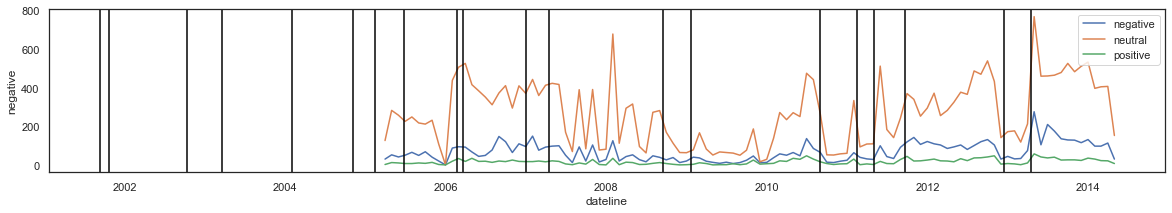

In [20]:
plt.figure(figsize = (20, 3))
sns.lineplot(data = df.resample('1M').sum(), x = 'dateline', y = 'negative', label = 'negative')
sns.lineplot(data = df.resample('1M').sum(), x = 'dateline', y = 'neutral', label = 'neutral')
sns.lineplot(data = df.resample('1M').sum(), x = 'dateline', y = 'positive', label = 'positive')
plt.axvline(dt.datetime(2001, 9, 11),  color = 'black') ## 9/11
plt.axvline(dt.datetime(2001, 10, 22), color = 'black') ## US leads assault on Taliban in Afghanistan
plt.axvline(dt.datetime(2002, 10, 11), color = 'black') ## Congress authorizes forces against Iraq
plt.axvline(dt.datetime(2003, 3, 19), color = 'black') ## US invades Iraq, starting war
plt.axvline(dt.datetime(2004, 2, 4), color = 'black') ## Facebook is formed
plt.axvline(dt.datetime(2004, 11, 7), color = 'black') ## Start of the Second Battle of Fallujah
plt.axvline(dt.datetime(2005, 2, 14), color = 'black') ## Youtube is created
plt.axvline(dt.datetime(2005, 6, 23), color = 'black') ## Reddit is created
plt.axvline(dt.datetime(2006, 2, 22), color = 'black') ## al-Askari Mosque bombing, Start of Iraqi War
plt.axvline(dt.datetime(2006, 3, 21), color = 'black') ## Twitter is created
plt.axvline(dt.datetime(2006, 12, 30), color = 'black') ## Saddam Hussein executed
plt.axvline(dt.datetime(2007, 4, 16), color = 'black') ## Virginia Tech Mass Shooting
plt.axvline(dt.datetime(2008, 9, 15), color = 'black') ## Start of Great Recession
plt.axvline(dt.datetime(2009, 1, 20), color = 'black') ## Barack Obama elected first black president
plt.axvline(dt.datetime(2010, 8, 30), color = 'black') ## US combat roll in Iraq ends
plt.axvline(dt.datetime(2011, 2, 14), color = 'black') ## Start of Arab Spring
plt.axvline(dt.datetime(2011, 5, 2), color = 'black') ## Navy Seals take down Osama Bin Laden
plt.axvline(dt.datetime(2011, 9, 19), color = 'black') ## Occupy Wallstreet
plt.axvline(dt.datetime(2012, 12, 14), color = 'black') ## Sandy Hook Shooting
plt.axvline(dt.datetime(2013, 4, 15), color = 'black') ## Boston Marathon Bombing


plt.legend()

## What is the relationship between tag and target (text_labels)

In [21]:
df.tags.value_counts()

['واشنطن']                                                                  11218
['القاعدة']                                                                 11201
['بوش']                                                                      9074
['أمريكا']                                                                   3199
['فيسبوك']                                                                   2528
                                                                            ...  
['واشنطن', 'مركز التجارة العالمي', 'القاعدة']                                   1
['أمريكا', 'بوش', 'أوباما', 'تشيني', '11 سبتمبر', 'القاعدة']                    1
['أمريكا', 'واشنطن', 'بوش', 'أوباما', 'مركز التجارة العالمي', 'القاعدة']        1
['أمريكا', 'بوش', 'أوباما', 'أسامة بن لادن']                                    1
['بوش', 'آل غور', 'القاعدة']                                                    1
Name: tags, Length: 435, dtype: int64

In [22]:
df.tags.nunique()

435

In [23]:
tag_count = dict(df['tags'].value_counts())
df['tag_count'] = df['tags']
df['tag_count'] = df['tag_count'].map(tag_count)

tags = df[df.tag_count > 50]

In [24]:
tags.tags.nunique() 

46

In [25]:
tags.head()

,index,id,url,headline,text,tags,source,text_label,text_score,headline_label,headline_score,False,negative,neutral,positive,country,tag_count
dateline,,,,,,,,,,,,,,,,,
2005-03-18,0,MTL_ARB_0409327,http://www.almustaqbal.com/v4/article.aspx?typ...,قداس في ديترويت لروح الرئيس الشهيد ورفاقه عاقو...,جاء في تقرير عن الصلاة التي أقيمت في كاتدرائية...,['واشنطن'],Almustaqbal,False,False,negative,0.582857,1,0,0,0,lebanon,11218
2005-03-18,1,MTL_ARB_0409331,http://www.almustaqbal.com/v4/article.aspx?typ...,"""""لا فرق بين الطائف والـ 1559 وعلى الدولة الاح...",دعا البطريرك الماروني الكاردينال مار نصرالله ب...,['بوش'],Almustaqbal,False,False,negative,0.608519,1,0,0,0,lebanon,9074
2005-03-19,12,MTL_ARB_0409472,http://www.almustaqbal.com/v4/article.aspx?typ...,شدّد على انسحاب سوري فوري وانتخابات حرة بإشراف...,شدد نائب مساعد وزيرة الخارجية الأميركية دايفيد...,"['واشنطن', 'بوش']",Almustaqbal,False,False,neutral,0.987818,1,0,0,0,lebanon,2464
2005-03-19,13,MTL_ARB_0409500,http://www.almustaqbal.com/v4/article.aspx?typ...,استقالة السفير الأميركي في أنقرة بعد انتقاده ز...,انقرة ـ حسني محلي والوكالات\nأعلن ناطق باسم ال...,"['واشنطن', 'بوش']",Almustaqbal,False,False,neutral,0.823856,1,0,0,0,lebanon,2464
2005-03-19,11,MTL_ARB_0409454,http://www.almustaqbal.com/v4/article.aspx?typ...,دعا الى تغيير ذهنية الماضي التي أوصلتنا الى ال...,"جبيل ـ """"المستقبل""""\nرأى العماد ميشال عون أن ت...",['بوش'],Almustaqbal,False,False,neutral,0.560592,1,0,0,0,lebanon,9074


In [26]:
df = tags

topics = {'America' : 'أمريكا',
            'American' : 'أمريكيّ',
            'American (f)' : 'أمريكيّة',
            'American (pl)' : 'أمريكيّين',
            'The United States' : 'الولايات المتحدة',
            'The United States' : 'دول موحّدة',
            'Washington' : 'واشنطن',
            'Bush' : 'بوش',
            'Obama' : 'أوباما',
            'Cheney' : 'تشيني',
            'Clinton' : 'كلينتون',
            'Osama Bin Laden' : 'أسامة بن لادن',
            'Al Gore' : 'آل غور',
            'World Trade Center' : 'مركز التجارة العالمي',
            '9/11' : '9/11',
            'September 11' : '11 سبتمبر',
            'Gulf War' : 'حرب الخليج',
            'Google' : 'غوغل',
            'Facebook' : 'فيسبوك',
            'Al Qaida' : 'القاعدة'}

In [27]:
def flip_key_value_pairs(dicts):
    
    res = dict((v,k) for k,v in dicts.items())    
    return res


def make_eng_tags(df_tags):
    eng_tags =[]
    
    rev_topics = flip_key_value_pairs(topics)
    for key, value in rev_topics.items():
        if key in df_tags:
            eng_tags.append(value)
            
    return eng_tags

df['english_tags'] = tags.tags.apply(make_eng_tags)

In [28]:
df

,index,id,url,headline,text,tags,source,text_label,text_score,headline_label,headline_score,False,negative,neutral,positive,country,tag_count,english_tags
dateline,,,,,,,,,,,,,,,,,,
2005-03-18,0,MTL_ARB_0409327,http://www.almustaqbal.com/v4/article.aspx?typ...,قداس في ديترويت لروح الرئيس الشهيد ورفاقه عاقو...,جاء في تقرير عن الصلاة التي أقيمت في كاتدرائية...,['واشنطن'],Almustaqbal,False,False,negative,0.582857,1,0,0,0,lebanon,11218,[Washington]
2005-03-18,1,MTL_ARB_0409331,http://www.almustaqbal.com/v4/article.aspx?typ...,"""""لا فرق بين الطائف والـ 1559 وعلى الدولة الاح...",دعا البطريرك الماروني الكاردينال مار نصرالله ب...,['بوش'],Almustaqbal,False,False,negative,0.608519,1,0,0,0,lebanon,9074,[Bush]
2005-03-19,12,MTL_ARB_0409472,http://www.almustaqbal.com/v4/article.aspx?typ...,شدّد على انسحاب سوري فوري وانتخابات حرة بإشراف...,شدد نائب مساعد وزيرة الخارجية الأميركية دايفيد...,"['واشنطن', 'بوش']",Almustaqbal,False,False,neutral,0.987818,1,0,0,0,lebanon,2464,"[Washington, Bush]"
2005-03-19,13,MTL_ARB_0409500,http://www.almustaqbal.com/v4/article.aspx?typ...,استقالة السفير الأميركي في أنقرة بعد انتقاده ز...,انقرة ـ حسني محلي والوكالات\nأعلن ناطق باسم ال...,"['واشنطن', 'بوش']",Almustaqbal,False,False,neutral,0.823856,1,0,0,0,lebanon,2464,"[Washington, Bush]"
2005-03-19,11,MTL_ARB_0409454,http://www.almustaqbal.com/v4/article.aspx?typ...,دعا الى تغيير ذهنية الماضي التي أوصلتنا الى ال...,"جبيل ـ """"المستقبل""""\nرأى العماد ميشال عون أن ت...",['بوش'],Almustaqbal,False,False,neutral,0.560592,1,0,0,0,lebanon,9074,[Bush]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-04-15,351,SHG_ARB_0136218,http://www.echoroukonline.com/ara/articles/201...,أوباما لبوتين: على كل القوات غير النظامية في أ...,أبلغ الرئيس الأمريكي باراك أوباما نظيره الروسي...,['أوباما'],Echoroukonline,neutral,0.9611957669258118,neutral,0.769957,0,0,1,0,algeria,2128,[Obama]
2014-04-16,352,SHG_ARB_0136306,http://www.echoroukonline.com/ara/articles/201...,"بعد 10 سنوات على الفضيحة.. غلق سجن """"أبو غريب""""",أعلن وزير العدل العراقي حسن الشمري، الثلاثاء، ...,"['واشنطن', 'القاعدة']",Echoroukonline,False,False,negative,0.773513,1,0,0,0,algeria,975,"[Washington, Al Qaida]"
2014-04-16,353,SHG_ARB_0136310,http://www.echoroukonline.com/ara/articles/201...,شرطة نيويورك تحل وحدة خاصة للتجسس على المسلمين,حلت إدارة شرطة نيويورك في الولايات المتحدة الأ...,['9/11'],Echoroukonline,neutral,0.6688314080238342,neutral,0.930232,0,0,1,0,algeria,179,[9/11]


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52103 entries, 2005-03-18 to 2014-04-17
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           52103 non-null  int64  
 1   id              52103 non-null  object 
 2   url             52103 non-null  object 
 3   headline        52103 non-null  object 
 4   text            52103 non-null  object 
 5   tags            52103 non-null  object 
 6   source          52103 non-null  object 
 7   text_label      52103 non-null  object 
 8   text_score      52103 non-null  object 
 9   headline_label  52103 non-null  object 
 10  headline_score  52103 non-null  float64
 11  False           52103 non-null  uint8  
 12  negative        52103 non-null  uint8  
 13  neutral         52103 non-null  uint8  
 14  positive        52103 non-null  uint8  
 15  country         52103 non-null  object 
 16  tag_count       52103 non-null  int64  
 17  english_tags  

In [30]:
df.english_tags.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[Washington]                               11218
[Al Qaida]                                 11201
[Bush]                                      9074
[America]                                   3199
[Facebook]                                  2528
[Washington, Bush]                          2464
[Obama]                                     2128
[Washington, Obama]                         1416
[Washington, Al Qaida]                       975
[Google]                                     971
[September 11]                               730
[Clinton]                                    725
[Washington, Clinton]                        415
[Osama Bin Laden, Al Qaida]                  395
[Bush, Al Qaida]                             364
[Cheney]                                     295
[Gulf War]                                   270
[Washington, Bush, Al Qaida]                 251
[America, Washington]                        228
[Google, Facebook]                           209
[Obama, Clinton]    

In [31]:
df = df.dropna()

In [32]:
df['english_tags']

dateline
2005-03-18              [Washington]
2005-03-18                    [Bush]
2005-03-19        [Washington, Bush]
2005-03-19        [Washington, Bush]
2005-03-19                    [Bush]
                       ...          
2014-04-15                   [Obama]
2014-04-16    [Washington, Al Qaida]
2014-04-16                    [9/11]
2014-04-16                [Facebook]
2014-04-17                   [Obama]
Name: english_tags, Length: 52103, dtype: object

In [33]:
df['string_tags'] = df['english_tags'].apply(lambda x: ','.join(map(str, x)))

In [34]:
df['string_tags'].unique()

array(['Washington', 'Bush', 'Washington,Bush', 'Al Qaida',
       'Bush,Clinton', 'Washington,Bush,September 11',
       'Washington,Osama Bin Laden,Al Qaida', 'Bush,Al Qaida', 'Google',
       'Washington,Al Qaida', 'Osama Bin Laden,Al Qaida', 'Gulf War',
       'Washington,Bush,Al Qaida', 'Clinton', 'Washington,Bush,Cheney',
       'Cheney', 'Washington,Bush,Clinton', 'Washington,Clinton', '9/11',
       'World Trade Center', 'America', 'Bush,Cheney', 'September 11',
       'Washington,September 11', 'Washington,Cheney', 'Osama Bin Laden',
       'America,Bush', 'America,Al Qaida',
       'Washington,September 11,Al Qaida', 'September 11,Al Qaida',
       'Bush,September 11', 'America,Washington', 'Obama',
       'Washington,Obama', 'Washington,Bush,Obama,Clinton',
       'Washington,Obama,Clinton', 'Obama,Clinton', 'Bush,Obama',
       'America,Obama', 'Washington,Bush,Obama', 'Facebook',
       'Washington,Obama,Al Qaida', 'Obama,Al Qaida',
       'America,Washington,Obama', 'Wash